# K-Means 

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

## Načítanie predspracovaných dát

In [2]:
from preprocessing.preprocessing import preprocess_data

df_train_model, df_test_model = preprocess_data()

print("\nDataset schema:")
df_train_model.printSchema()

print("\nSample records:")
df_train_model.select("features", "Accident_Severity").show(5, truncate=False)


Dataset schema:
root
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: integer (nullable = true)
 |-- Junction_Control: integer (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Number: integer (nullable = true)
 |-- Urban_or_Rural_Area: integer (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: integer (nullable = true)
 |-- Vehicle_Reference: integer (nullable = true)
 |-- Casualty_Reference: integer (nullable = true)
 |-- Casualty_Severity: integer (nullable = true)
 |-- Casualty_Type: integer (nullable = true)
 |

## Hľadanie optimálneho počtu cluster-ov

Computing cost for different values of k...
k=2, WSSSE=4649915463828867.0000
k=3, WSSSE=3503903265997828.0000
k=4, WSSSE=1903518108393668.2500
k=5, WSSSE=1526985178258468.2500
k=6, WSSSE=1366868101951217.0000
k=7, WSSSE=1286174417851217.5000
k=8, WSSSE=971796163727299.1250
k=9, WSSSE=1129495171981973.2500
k=10, WSSSE=814358038123113.6250


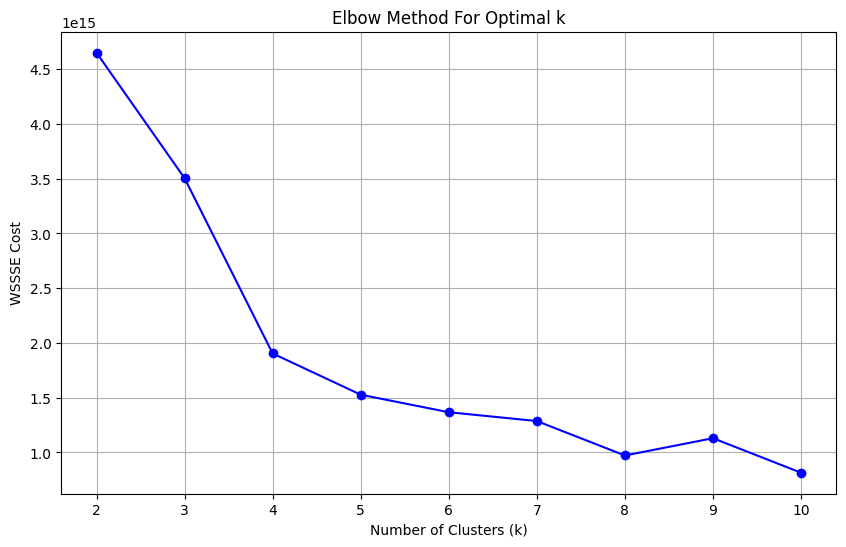

In [3]:
# Function to compute cost (WSSSE) for different k values
def compute_cost(df, k_values, features_col="features"):
    costs = []
    for k in k_values:
        kmeans = KMeans(k=k, seed=42, featuresCol=features_col)
        model = kmeans.fit(df)
        wssse = model.summary.trainingCost
        costs.append(wssse)
        print(f"k={k}, WSSSE={wssse:.4f}")
    return costs

# Define a range of k values to test
k_values = list(range(2, 11))

# Compute cost for each k
print("Computing cost for different values of k...")
costs = compute_cost(df_train_model, k_values)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, costs, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE Cost')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.xticks(k_values)
plt.show()

## Trénovanie K-means modelu s optimálnym počtom cluster-ov

In [4]:
# Set the optimal k value based on the elbow plot
optimal_k = 5  # This should be adjusted based on the elbow curve results

# Train K-means with the optimal k
kmeans = KMeans(k=optimal_k, seed=42, featuresCol="features")
model = kmeans.fit(df_train_model)

# Print cluster centers
centers = model.clusterCenters()
print(f"Cluster Centers for k={optimal_k}:")
for i, center in enumerate(centers):
    # Print the first few dimensions of each center for brevity
    print(f"Cluster {i}: {center[:5]}...")

# Evaluate clustering by computing Silhouette score
predictions = model.transform(df_train_model)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"\nSilhouette with squared euclidean distance = {silhouette:.4f}")

Cluster Centers for k=5:
Cluster 0: [4.00592395e+05 4.35200391e+05 1.13368799e+01 2.31280006e+00
 2.26319014e+00]...
Cluster 1: [2.95657655e+05 6.93206707e+05 9.26809803e+01 2.10469887e+00
 1.93255292e+00]...
Cluster 2: [4.32581550e+05 3.10026860e+05 2.71828934e+01 2.26847991e+00
 2.00132415e+00]...
Cluster 3: [5.30973792e+05 1.82156726e+05 2.87212782e+01 2.46282526e+00
 2.07315719e+00]...
Cluster 4: [3.21051261e+05 1.46059158e+05 5.42929970e+01 2.39909016e+00
 2.23231321e+00]...

Silhouette with squared euclidean distance = 0.6237


## Analýza cluster-ov

In [5]:
# Apply the model to the training data
clustered_data = model.transform(df_train_model)

# Examine the distribution of Accident Severity within each cluster
severity_by_cluster = clustered_data.groupBy("prediction", "Accident_Severity").count().orderBy("prediction", "Accident_Severity")
print("Distribution of Accident Severity by Cluster:")
severity_by_cluster.show()

# Create a more detailed view of the cluster characteristics
print("Cluster Summary Statistics:")
cluster_stats = clustered_data.groupBy("prediction").agg({
    "Accident_Severity": "mean",  # Average severity
    "*": "count"  # Count of records in each cluster
}).orderBy("prediction")

cluster_stats = cluster_stats.withColumnRenamed("avg(Accident_Severity)", "avg_severity")
cluster_stats = cluster_stats.withColumnRenamed("count(1)", "cluster_size")
cluster_stats.show()

Distribution of Accident Severity by Cluster:
+----------+-----------------+-----+
|prediction|Accident_Severity|count|
+----------+-----------------+-----+
|         0|                1| 1390|
|         0|                2|11155|
|         0|                3|67439|
|         1|                1|  569|
|         1|                2| 3325|
|         1|                3|14387|
|         2|                1| 1209|
|         2|                2| 7410|
|         2|                3|47266|
|         3|                1| 1679|
|         3|                2|14929|
|         3|                3|93265|
|         4|                1|  901|
|         4|                2| 4798|
|         4|                3|30571|
+----------+-----------------+-----+

Cluster Summary Statistics:
+----------+------------------+------------+
|prediction|      avg_severity|cluster_size|
+----------+------------------+------------+
|         0|2.8257776555311063|       79984|
|         1| 2.755866746895684|       1828

## Vizualizácia cluster-ov

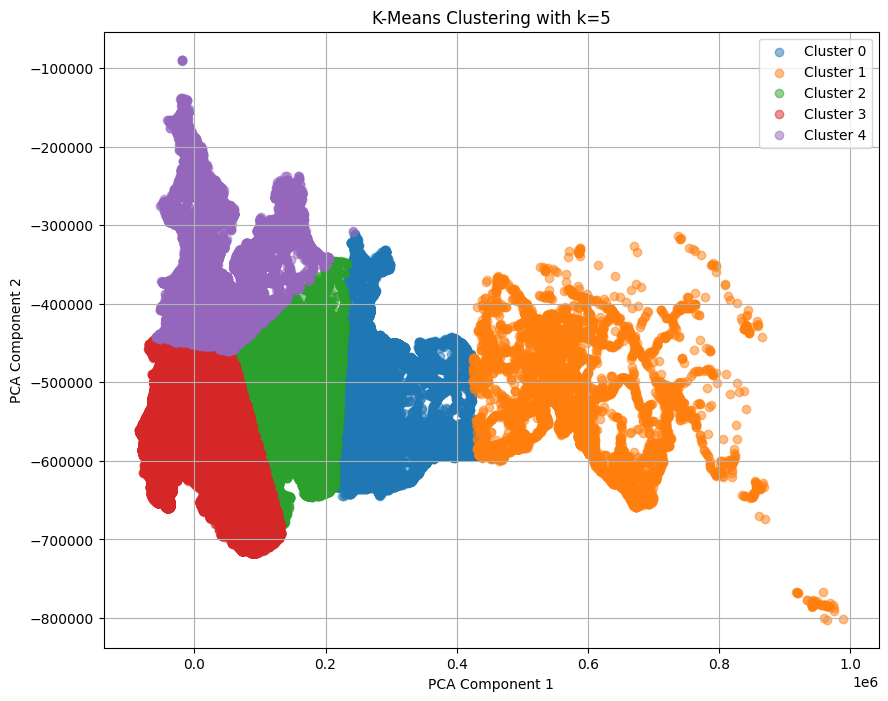

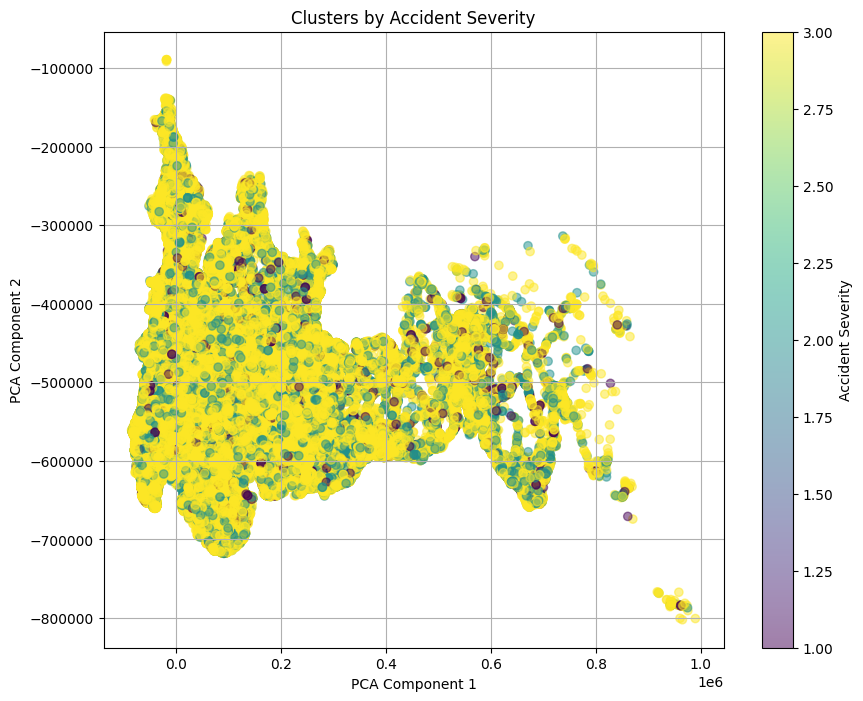

In [6]:
from pyspark.ml.feature import PCA

# Apply PCA to reduce dimensions for visualization
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_data)
result = pca_model.transform(clustered_data)

# Convert to pandas for easier plotting
pandas_df = result.select("pca_features", "prediction", "Accident_Severity").toPandas()

# Extract the PCA components
pandas_df["pca1"] = pandas_df["pca_features"].apply(lambda x: float(x[0]))
pandas_df["pca2"] = pandas_df["pca_features"].apply(lambda x: float(x[1]))

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_data = pandas_df[pandas_df["prediction"] == cluster]
    plt.scatter(cluster_data["pca1"], cluster_data["pca2"], label=f"Cluster {cluster}", alpha=0.5)

plt.title(f"K-Means Clustering with k={optimal_k}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Plot clusters colored by severity
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pandas_df["pca1"], pandas_df["pca2"], c=pandas_df["Accident_Severity"], cmap="viridis", alpha=0.5)
plt.colorbar(scatter, label="Accident Severity")
plt.title("Clusters by Accident Severity")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

## Uloženie modelu a výsledkov

In [7]:
# Create a directory for models if it doesn't exist
import os
models_dir = os.path.join("..", "models")
os.makedirs(models_dir, exist_ok=True)

# Save the K-means model
model_path = os.path.join(models_dir, "kmeans_model")
model.save(model_path)
print(f"Model saved to {model_path}")

# Save a summary of the clusters
cluster_summary = clustered_data.groupBy("prediction").count().orderBy("prediction")
print("\nCluster sizes:")
cluster_summary.show()

# Export a sample of the clustered data for inspection
sample_path = os.path.join(models_dir, "kmeans_sample_results.csv")
clustered_data.select("prediction", "Accident_Severity").sample(False, 0.01).toPandas().to_csv(sample_path, index=False)
print(f"Sample results saved to {sample_path}")

Py4JJavaError: An error occurred while calling o1642.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.hadoop.mapred.FileOutputCommitter.setupJob(FileOutputCommitter.java:131)
	at org.apache.hadoop.mapred.OutputCommitter.setupJob(OutputCommitter.java:265)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:79)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1623)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1623)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1609)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1609)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.clustering.InternalKMeansModelWriter.write(KMeans.scala:221)
	at org.apache.spark.ml.util.GeneralMLWriter.saveImpl(ReadWrite.scala:260)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:242)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:94)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:377)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:969)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:199)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:222)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1125)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1134)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 25 more
